# Simulated/"hybrid" Motion

In [1]:
from typing import List
from matplotlib import pyplot as plt
import numpy as np

In [2]:
WASA_THRESHOLD = 0.93
BALANCE_WEIGHTS = True

### Comparison: WASA93, ROC AUC, Cohen's Kappa

* WASA93: <u>W</u>ake <u>A</u>ccuracy when <u>S</u>leep <u>A</u>ccuracy is fixed at <u>93%</u>

In [3]:
from pisces.utils import pad_to_hat, plot_scores_CDF, plot_scores_PDF, add_rocs
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score


def split_analysis(y, y_hat_sleep_proba, sleep_accuracy: float = WASA_THRESHOLD, balancing: bool = BALANCE_WEIGHTS):

    y_flat = y.reshape(-1,)
    n_sleep = np.sum(y_flat > 0)
    n_wake = np.sum(y_flat == 0)
    N = n_sleep + n_wake

    balancing_weights_ignore_mask = np.where(y_flat > 0, N / n_sleep, N / n_wake) \
        if balancing else np.ones_like(y_flat)
    balancing_weights_ignore_mask /= np.sum(balancing_weights_ignore_mask) # sums to 1.0

    # adjust y to match the lenght of y_hat, which was padded to fit model constraints
    y_padded = pad_to_hat(y_flat, y_hat_sleep_proba)
    # make a mask to ignore the padded values, so they aren't counted against us
    mask = pad_to_hat(balancing_weights_ignore_mask, y_hat_sleep_proba)

    # also ignore any unscored or missing values.
    y_to_score = pad_to_hat(y_flat >= 0, y_hat_sleep_proba)
    mask *= y_to_score
    # roc_auc will complain if -1 is in y_padded
    y_padded *= y_to_score 

    # ROC analysis
    fprs, tprs, thresholds = roc_curve(y_padded, y_hat_sleep_proba, sample_weight=mask)

    # Sleep accuracy = (n sleep correct) / (n sleep) = TP/AP = TPR
    wasa_threshold = thresholds[np.sum(tprs <= sleep_accuracy)]
    y_guess = y_hat_sleep_proba > wasa_threshold

    # # WASA X
    guess_right = y_guess == y_padded
    y_wake = y_padded == 0
    wake_accuracy = np.sum(y_wake * guess_right * y_to_score) / np.sum(n_wake)
     
    return {
        "y_padded": y_padded,
        "y_hat": y_hat_sleep_proba,
        "mask": mask,
        "kappa": cohen_kappa_score(y_padded, y_guess, sample_weight=mask),
        "auc": roc_auc_score(y_padded, y_hat_sleep_proba, sample_weight=mask),
        "roc_curve": {"tprs": tprs,
                      "fprs": fprs,
                      "thresholds": thresholds
        }, 
        f"wasa{int(100 * sleep_accuracy)}_threshold": wasa_threshold,
        f"wasa{int(100 * sleep_accuracy)}": wake_accuracy, 
    }


In [4]:
import matplotlib.pyplot as plt
from pisces.experiments import DataSetObject


sets = DataSetObject.find_data_sets("../data_sets")
walch = sets['walch_et_al']
hybrid = sets['hybrid_motion']

# Walch et al. data set

## (MO) Pretrained UNet evaluation
We have the trained weights from Mads Olsen et al.'s _ResUNet_ model, saved as a tensorflow lite model with a wrapper for our system. This section calls that on accelerometer recordings in the `'walch_et_al'` data set.

In [5]:
from pisces.experiments import MOResUNetPretrained


mo = MOResUNetPretrained(sampling_hz=32)



In [6]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)
DATA_SET = walch

mo_preprocessed_data_walch = [
    (d, i) 
    for (d, i) in zip(
        mo.prepare_set_for_training(DATA_SET, DATA_SET.ids),
        DATA_SET.ids) 
    if d is not None
]

evaluations_walch: List[dict] = []
for i, ((X, y), id) in enumerate(mo_preprocessed_data_walch):
    y_hat_proba = mo.predict_probabilities(X)
    y_hat_sleep_proba = (1 - y_hat_proba[:, :, 0]).reshape(-1,)
    analysis = split_analysis(y, y_hat_sleep_proba)
    evaluations_walch.append(analysis)
    print(f"Processing {i+1} of {len(mo_preprocessed_data_walch)} ({id})... AUROC: {analysis['auc']}")
mo_aucs_walch = [e["auc"] for e in evaluations_walch]
mo_fprs_walch = [e["roc_curve"]["fprs"] for e in evaluations_walch]
mo_tprs_walch = [e["roc_curve"]["tprs"] for e in evaluations_walch]


getting needed X, y for 1818471
sampling hz: 32
resampling to 32Hz (0.03125s) from 50 Hz (0.01999s)
getting needed X, y for 1360686
getting needed X, y for 1455390
getting needed X, y for 3509524
getting needed X, y for 1449548
getting needed X, y for 2598705
getting needed X, y for 1066528
getting needed X, y for 2638030
getting needed X, y for 4018081
sampling hz: 32
sampling hz: 32
sampling hz: 32
resampling to 32Hz (0.03125s) from 66 Hz (0.01501s)
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
sampling hz: 32
getting needed X, y for 5383425
sampling hz: 32
resampling to 32Hz (0.03125s) from 50 Hz (0.01999s)
resampling to 32Hz (0.03125s) from 50 Hz (0.01986s)
sampling hz: 32
sampling hz: 32
getting needed X, y for 4426783
sampling hz: 32
getting needed X, y for 5132496
getting needed X, y for 4314139
resampling to 32Hz (0.03125s) from 50 Hz (0.01977s)
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
resampling to 32Hz (0.03125s) from 66 Hz (0.01502s)
resampling to 32Hz (0.03

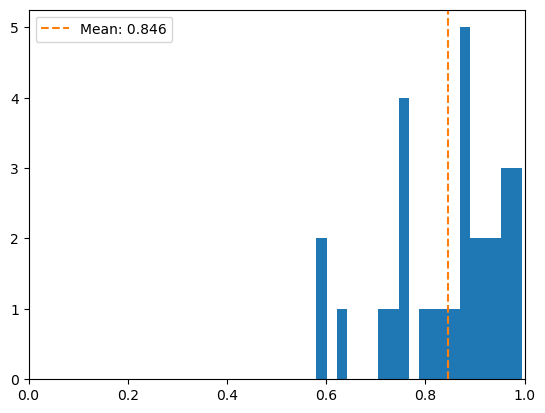

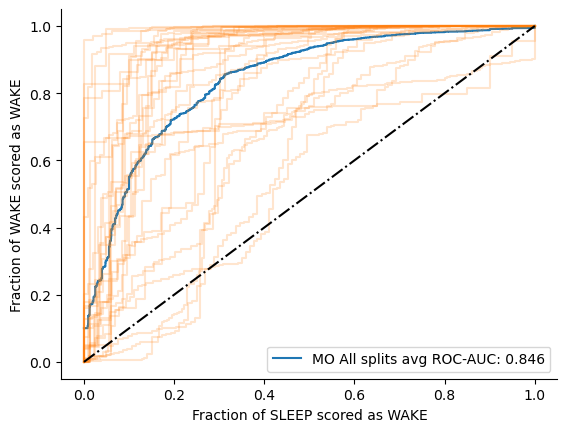

In [7]:
plot_scores_PDF(mo_aucs_walch)

add_rocs(mo_fprs_walch, mo_tprs_walch, roc_group_name="MO")

### debugging

In [8]:
import random

from pisces.experiments import MOResUNetPretrained


w = sets['walch_et_al']
subj = w.ids[1]
(X, y), id  = mo_preprocessed_data_walch[1]
print("X.shape =", X.shape)
spec = X[0, 1:, :, 0].T

print("spec.shape =", spec.shape)


X.shape = (1, 15360, 32, 2)
spec.shape = (32, 15359)


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_spectrogram(preprocessed_data, idx):
    (X, y), id = preprocessed_data[idx]
    spec = X[0, 1:, :, 0].T

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

    # ax1.imshow(.T)

    img = ax1.imshow(spec, origin="lower", aspect="auto")#, vmin=vmin, vmax=vmax)
    ax1.set_title('Spectrogram, Time : Freq')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Freq')

    axins = inset_axes(ax1,
                    width="5%",  # width = 5% of parent_bbox width
                    height="75%",  # height : 50%
                    loc='center right')

    plt.colorbar(img, cax=axins, orientation="vertical")

    ax3.plot(spec)
    ax3.set_title('Spectrogram, Frequency : Power ')
    ax3.set_xlabel('Freq')
    ax3.set_ylabel('Power')
    ax3.set_xlim(0, 31)#spec.shape[0])


    ax2.plot(spec.T)
    ax2.set_title('Spectrogram, Time : Power')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Power')
    ax2.set_xlim(0, spec.shape[1])

    plt.tight_layout(pad=0.3)
    fig.suptitle(f"Subject {id}")
    plt.show()


In [10]:

def plot_predictions(evaluations, y_time, idx):
    y_pad = evaluations[idx]["y_padded"][:len(y_time)]
    y_pred = evaluations[idx]["y_hat"][:len(y_time)]
    y_mask = evaluations[idx]["mask"][:len(y_time)]

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(y_time, y_pad, label="True")
    ax.plot(y_time, y_pred, label="Predicted")
    ax.plot(y_time, y_mask, label="Mask")
    ax.legend(loc='upper right')

/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_82325/3078200158.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


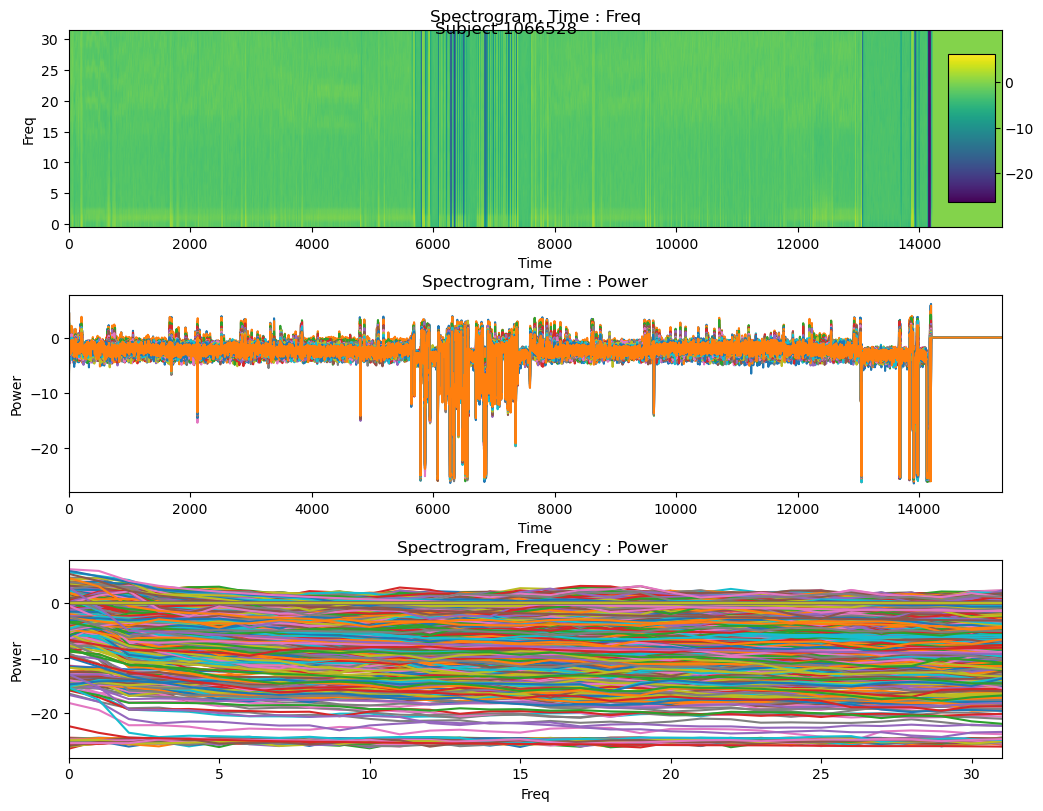

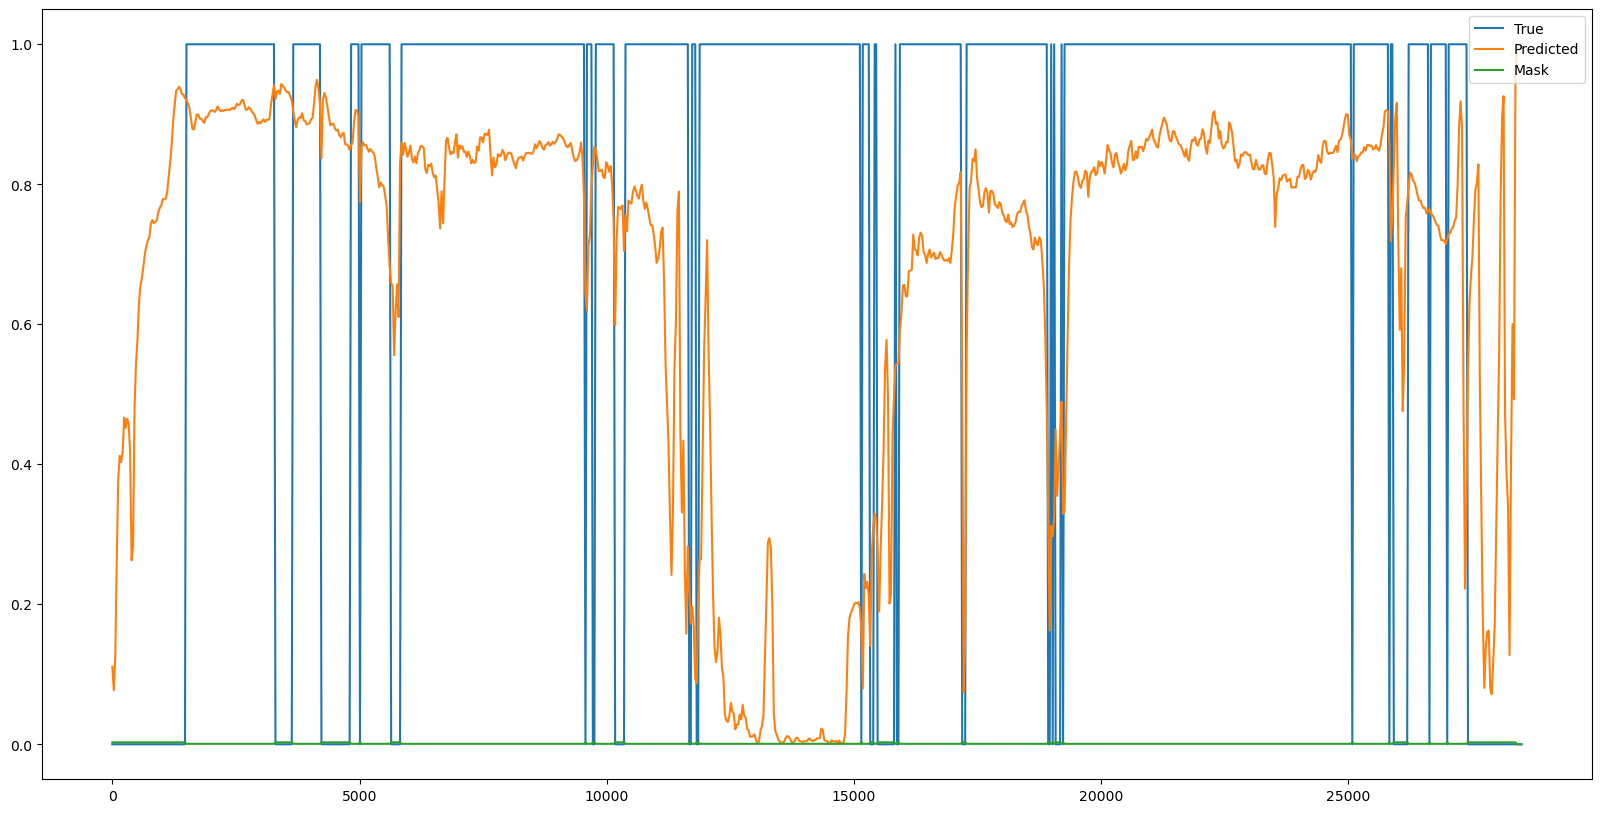

In [11]:
index = 0
psg = w.get_feature_data("psg", w.ids[index])
psg_time = psg[:, 0].to_numpy()

plot_spectrogram(mo_preprocessed_data_walch, index)
plot_predictions(evaluations=evaluations_walch, y_time=psg_time, idx=index)

## LOO + SGD Log Reg classifier
Adding LOOX can be achieved by training on 'walch_et_al' and testing on 'hybrid_data'.

In [12]:

from pisces.experiments import LeaveOneOutSplitter, SGDLogisticRegression, run_splits

DATA_SET = walch
loo = LeaveOneOutSplitter()

split_models, log_reg_preprocessed_data_walch, splits = run_splits(loo, DATA_SET, SGDLogisticRegression)

ID 7749105 not found in walch_et_al


31it [00:02, 11.24it/s]


In [13]:

log_reg_preprocessed_data_walch = [l for l in log_reg_preprocessed_data_walch if l[0] is not None]
log_reg_evaluations_walch: List[dict] = []
for i, ((X, y), id) in enumerate(log_reg_preprocessed_data_walch):
    y_hat_proba = split_models[i].predict_probabilities(X)
    analysis = split_analysis(y, y_hat_sleep_proba, balancing=False)
    log_reg_evaluations_walch.append(analysis)
    print(f"Processing {i+1} of {len(log_reg_preprocessed_data_walch)} ({id})... AUROC: {analysis['auc']}")
log_reg_aucs_walch = [e["auc"] for e in log_reg_evaluations_walch]
log_reg_fprs_walch = [e["roc_curve"]["fprs"] for e in log_reg_evaluations_walch]
log_reg_tprs_walch = [e["roc_curve"]["tprs"] for e in log_reg_evaluations_walch]


Processing 1 of 30 (1066528)... AUROC: 0.609887005649715
Processing 2 of 30 (1360686)... AUROC: 0.8193248788916659
Processing 3 of 30 (1449548)... AUROC: 0.42920559687953497
Processing 4 of 30 (1455390)... AUROC: 0.5730345525121707
Processing 5 of 30 (1818471)... AUROC: 0.8637130801687802
Processing 6 of 30 (2598705)... AUROC: 0.5920503211991467
Processing 7 of 30 (2638030)... AUROC: 0.601345158906137
Processing 8 of 30 (3509524)... AUROC: 0.7677114195124491
Processing 9 of 30 (3997827)... AUROC: 0.8761843515541268
Processing 10 of 30 (4018081)... AUROC: 0.7545047732696898
Processing 11 of 30 (4314139)... AUROC: 0.728076474284171
Processing 12 of 30 (4426783)... AUROC: 0.7776756247053245
Processing 13 of 30 (46343)... AUROC: 0.7489339019189766
Processing 14 of 30 (5132496)... AUROC: 0.8145257681220545
Processing 15 of 30 (5383425)... AUROC: 0.9543449197860963
Processing 16 of 30 (5498603)... AUROC: 0.3537023723939627
Processing 17 of 30 (5797046)... AUROC: 0.42611367353855395
Processin

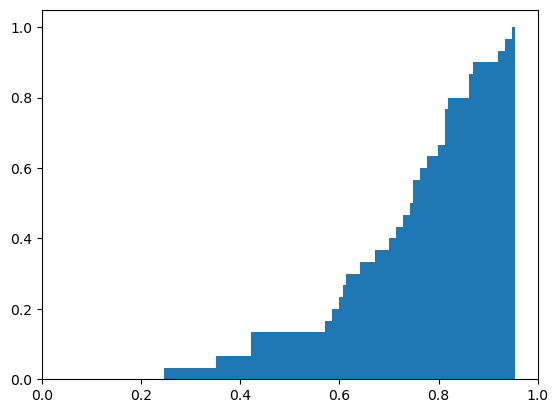

In [14]:
plot_scores_CDF(log_reg_aucs_walch)

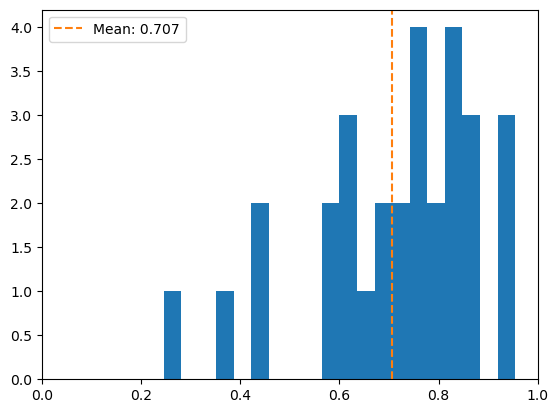

In [15]:
plot_scores_PDF(log_reg_aucs_walch)

### Comparision: ROC

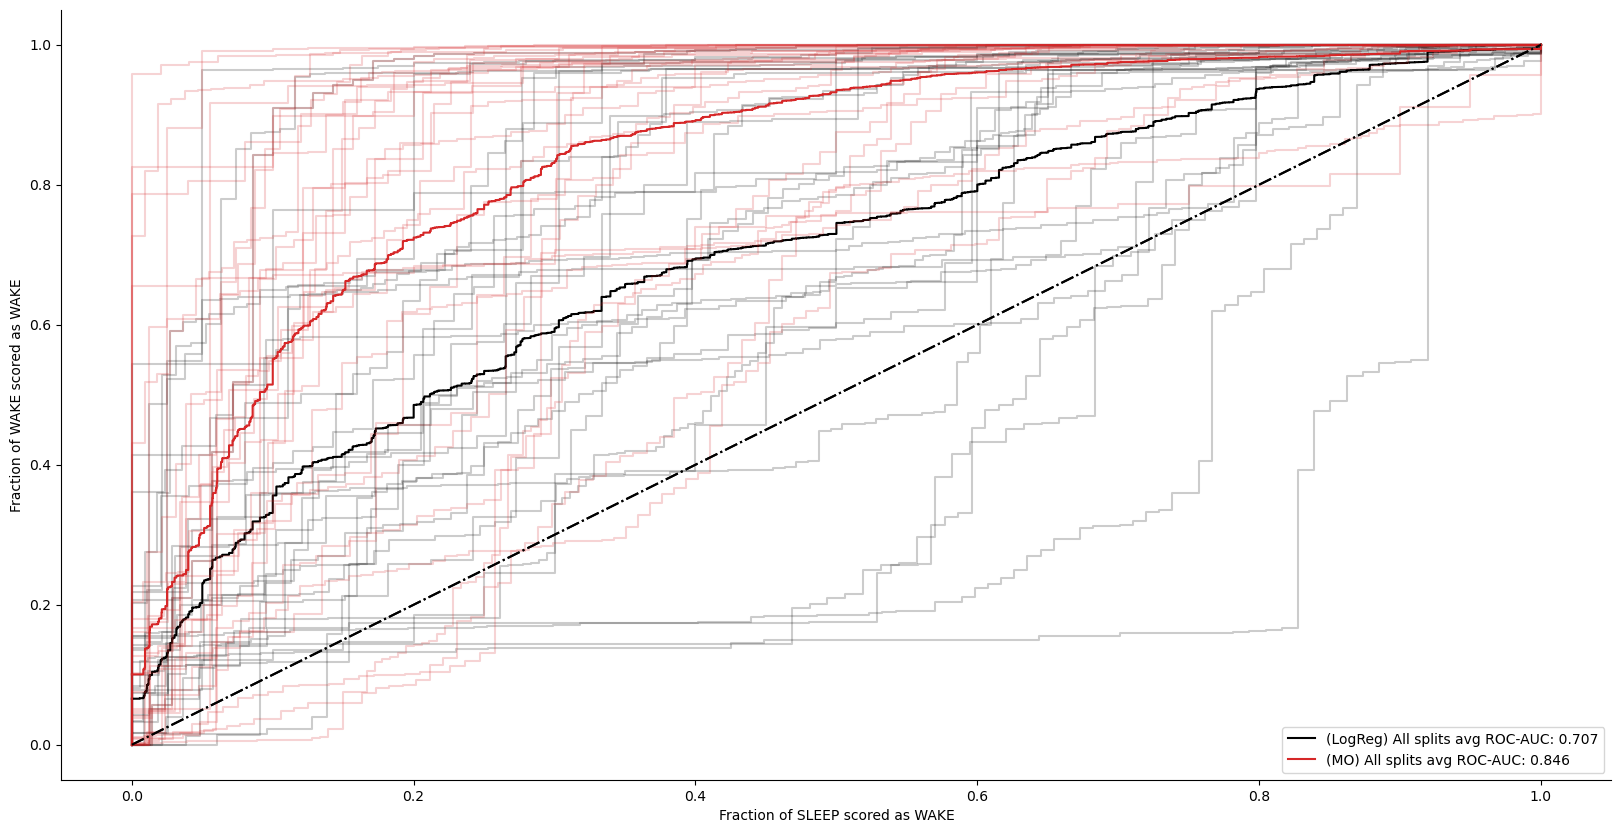

In [27]:


fig, ax = plt.subplots(figsize=(20, 10))
lr_color = "black"
mo_color = "tab:red"

add_rocs(
    fprs=log_reg_fprs_walch, 
    tprs=log_reg_tprs_walch,
    avg_curve_color=lr_color,
    specific_curve_color=lr_color,
    roc_group_name="(LogReg)",
    ax=ax,
)

add_rocs(
    fprs=mo_fprs_walch,
    tprs=mo_tprs_walch,
    avg_curve_color=mo_color,
    specific_curve_color=mo_color,
    roc_group_name="(MO)",
    ax=ax
)
ax.legend(loc='lower right')

# Hybrid data set

In [17]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)
DATA_SET = hybrid

mo_preprocessed_data_hybrid = [
    (d, i) 
    for (d, i) in zip(
        mo.prepare_set_for_training(DATA_SET, DATA_SET.ids),
        DATA_SET.ids) 
    if d is not None
]

evaluations_hybrid: List[dict] = []
for i, ((X, y), id) in enumerate(mo_preprocessed_data_hybrid):
    y_hat_proba = mo.predict_probabilities(X)
    y_hat_sleep_proba = (1 - y_hat_proba[:, :, 0]).reshape(-1,)
    analysis = split_analysis(y, y_hat_sleep_proba)
    evaluations_hybrid.append(analysis)
    print(f"Processing {i+1} of {len(mo_preprocessed_data_hybrid)} ({id})... AUROC: {analysis['auc']}")
mo_aucs_hybrid = [e["auc"] for e in evaluations_hybrid]
mo_fprs_hybrid = [e["roc_curve"]["fprs"] for e in evaluations_hybrid]
mo_tprs_hybrid = [e["roc_curve"]["tprs"] for e in evaluations_hybrid]


getting needed X, y for 5498603
getting needed X, y for 1066528
getting needed X, y for 1360686
getting needed X, y for 46343
getting needed X, y for 4426783
getting needed X, y for 2598705
getting needed X, y for 4314139
getting needed X, y for 5383425
getting needed X, y for 2638030
getting needed X, y for 5132496
getting needed X, y for 3997827
getting needed X, y for 1818471
getting needed X, y for 1455390
getting needed X, y for 3509524
getting needed X, y for 1449548
getting needed X, y for 4018081
sampling hz: 32
resampling to 32Hz (0.03125s) from 10 Hz (0.09990s)
sampling hz: 32
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
sampling hz: 32
sampling hz: 32
resampling to 32Hz (0.03125s) from 50 Hz (0.01997s)
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
sampling hz: 32
resampling to 32Hz (0.03125s) from 66 Hz (0.01505s)
sampling hz: 32
sampling hz: 32
sampling hz: 32
sampling hz: 32
sampling hz: 32
sampling hz: 32
sampling hz: 32
sampling hz: 32
sampling hz: 32
resamp

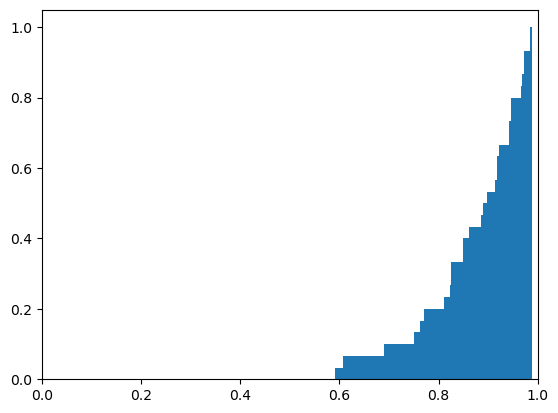

In [18]:

plot_scores_CDF(mo_aucs_hybrid)

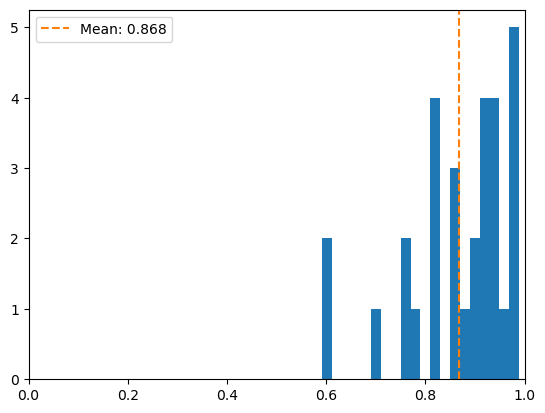

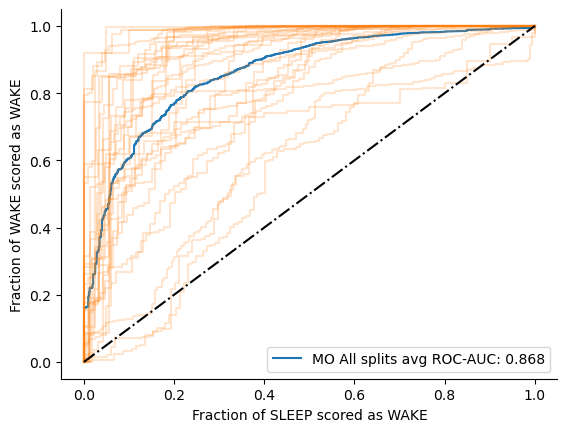

In [19]:

# y so terrible??
# probably timestamp/gap issues
# look at worst ones
plot_scores_PDF(mo_aucs_hybrid)

add_rocs(mo_fprs_hybrid, mo_tprs_hybrid, roc_group_name="MO")

In [20]:

log_reg_preprocessed_data_hybrid = [
    (d, DATA_SET.ids[i])
    for i in range(len(split_models))
    if (d := split_models[i].get_needed_X_y(DATA_SET, DATA_SET.ids[i])) is not None
]

log_reg_evaluations_hybrid: List[dict] = []
for i, ((X, y), id) in enumerate(log_reg_preprocessed_data_hybrid):
    y_hat_proba = split_models[i].predict_probabilities(X)
    analysis = split_analysis(y, y_hat_sleep_proba)
    log_reg_evaluations_hybrid.append(analysis)
    print(f"Processing {i+1} of {len(log_reg_preprocessed_data_hybrid)} ({id})... AUROC: {analysis['auc']}")
log_reg_aucs_hybrid = [e["auc"] for e in log_reg_evaluations_hybrid]
log_reg_fprs_hybrid = [e["roc_curve"]["fprs"] for e in log_reg_evaluations_hybrid]
log_reg_tprs_hybrid = [e["roc_curve"]["tprs"] for e in log_reg_evaluations_hybrid]


ID 7749105 not found in hybrid_motion
Processing 1 of 29 (1066528)... AUROC: 0.6046936114732728
Processing 2 of 29 (1360686)... AUROC: 0.8105155975192105
Processing 3 of 29 (1449548)... AUROC: 0.4383872416891308
Processing 4 of 29 (1455390)... AUROC: 0.5358646328795654
Processing 5 of 29 (1818471)... AUROC: 0.869514767932493
Processing 6 of 29 (2598705)... AUROC: 0.5880888650963629
Processing 7 of 29 (2638030)... AUROC: 0.572480906627251
Processing 8 of 29 (3509524)... AUROC: 0.7417582417582418
Processing 9 of 29 (3997827)... AUROC: 0.9040514469453392
Processing 10 of 29 (4018081)... AUROC: 0.6963203860578526
Processing 11 of 29 (4314139)... AUROC: 0.7849441253029356
Processing 12 of 29 (4426783)... AUROC: 0.7485792778649919
Processing 13 of 29 (46343)... AUROC: 0.8034616831807347
Processing 14 of 29 (5132496)... AUROC: 0.8030303030303041
Processing 15 of 29 (5383425)... AUROC: 0.9548878205128207
Processing 16 of 29 (5498603)... AUROC: 0.2821931072932426
Processing 17 of 29 (5797046)..

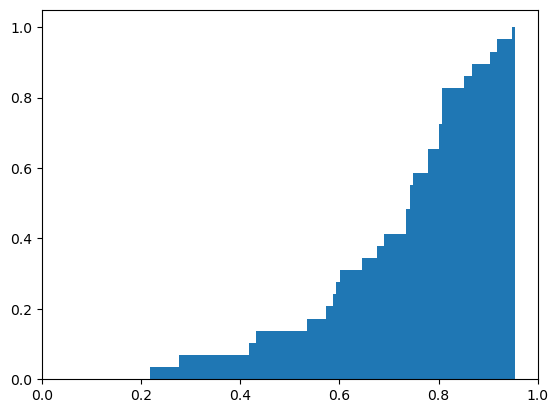

In [21]:


plot_scores_CDF(log_reg_aucs_hybrid)

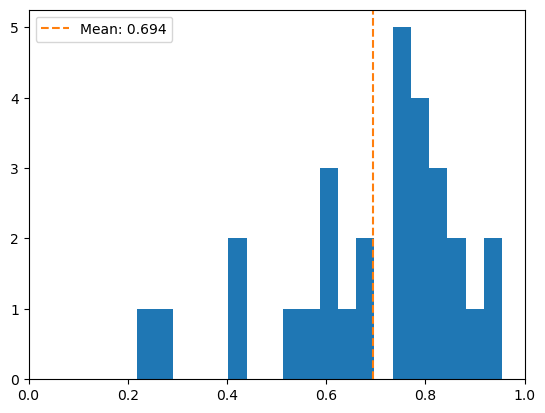

In [22]:
plot_scores_PDF(log_reg_aucs_hybrid)

### Comparision ROC

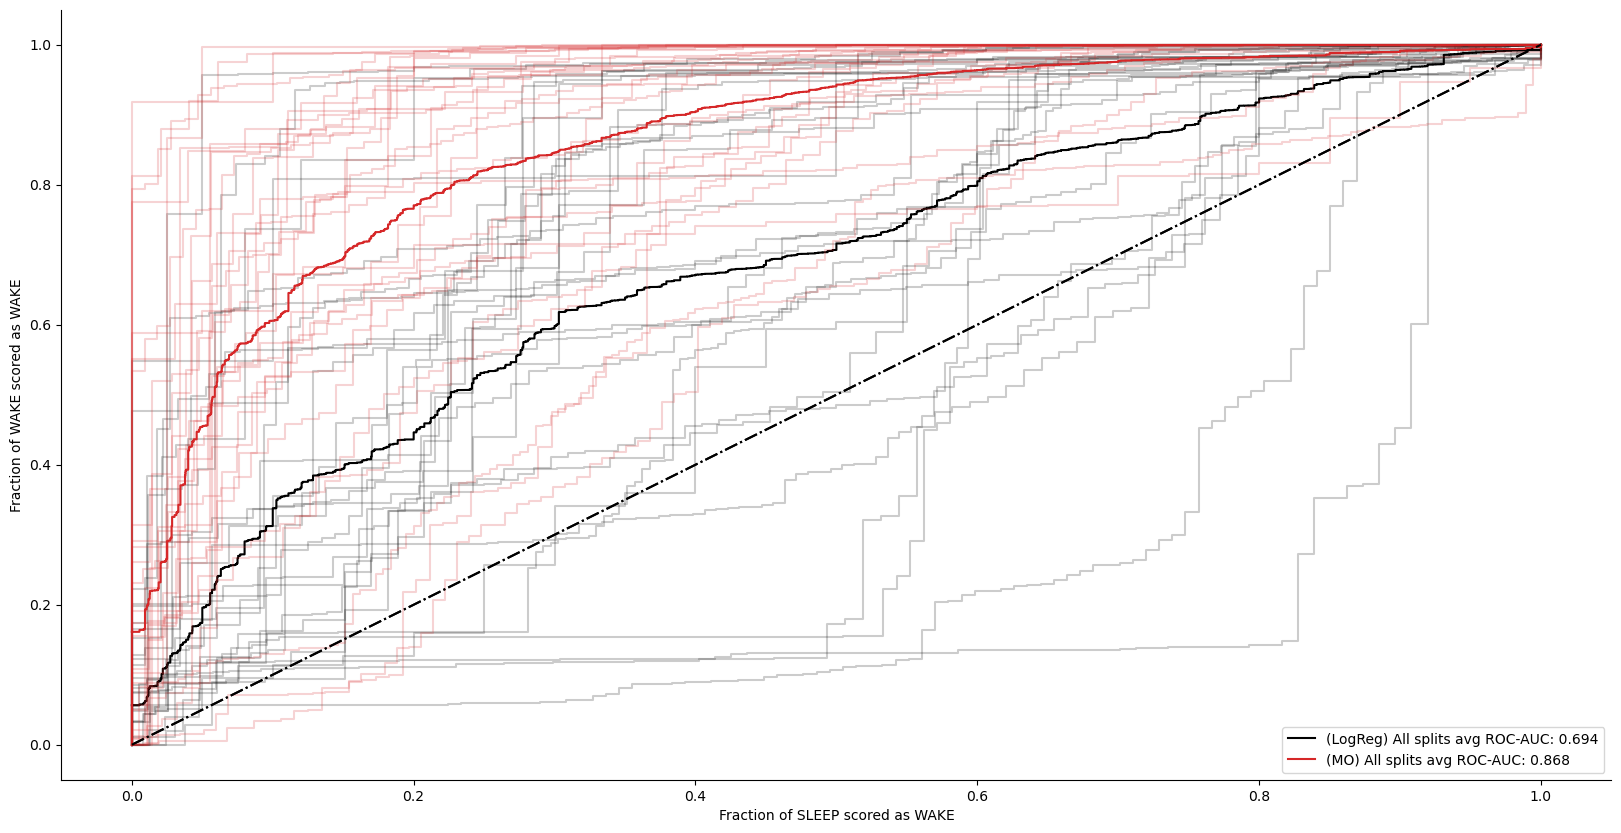

In [28]:


fig, ax = plt.subplots(figsize=(20, 10))
add_rocs(
    fprs=log_reg_fprs_hybrid,
    tprs=log_reg_tprs_hybrid,
    # min_auc=0.7, 
    avg_curve_color=lr_color,
    specific_curve_color=lr_color,
    roc_group_name="(LogReg)",
    ax=ax,
)

add_rocs(
    fprs=mo_fprs_hybrid,
    tprs=mo_tprs_hybrid,
    avg_curve_color=mo_color,
    specific_curve_color=mo_color,
    # min_auc=0.7,
    roc_group_name="(MO)",
    ax=ax
)
ax.legend(loc='lower right')

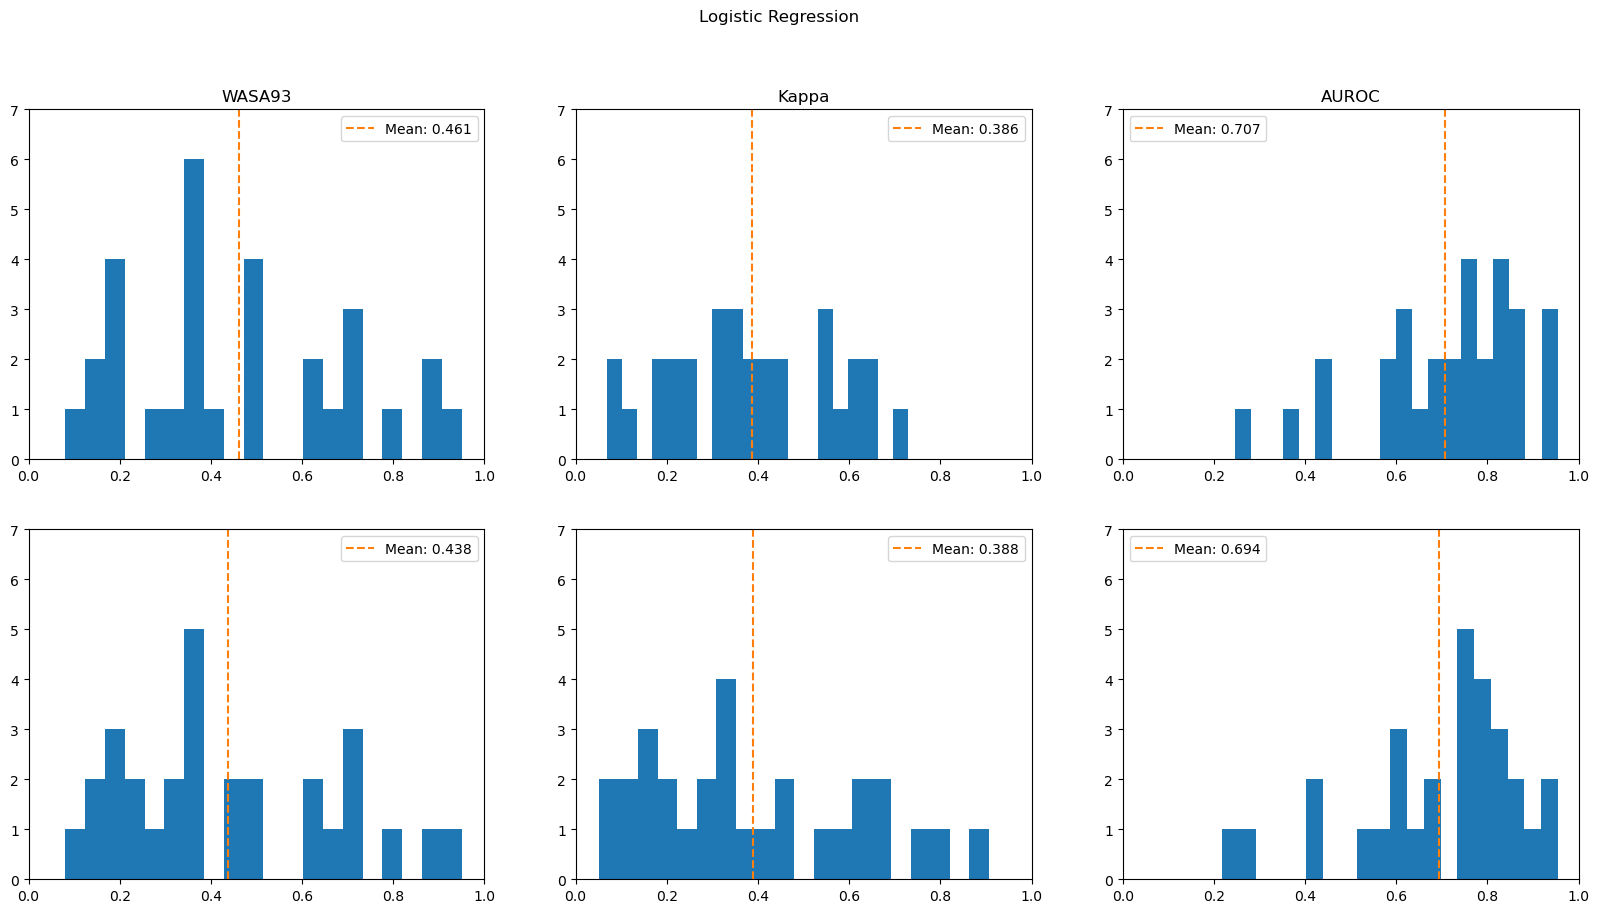

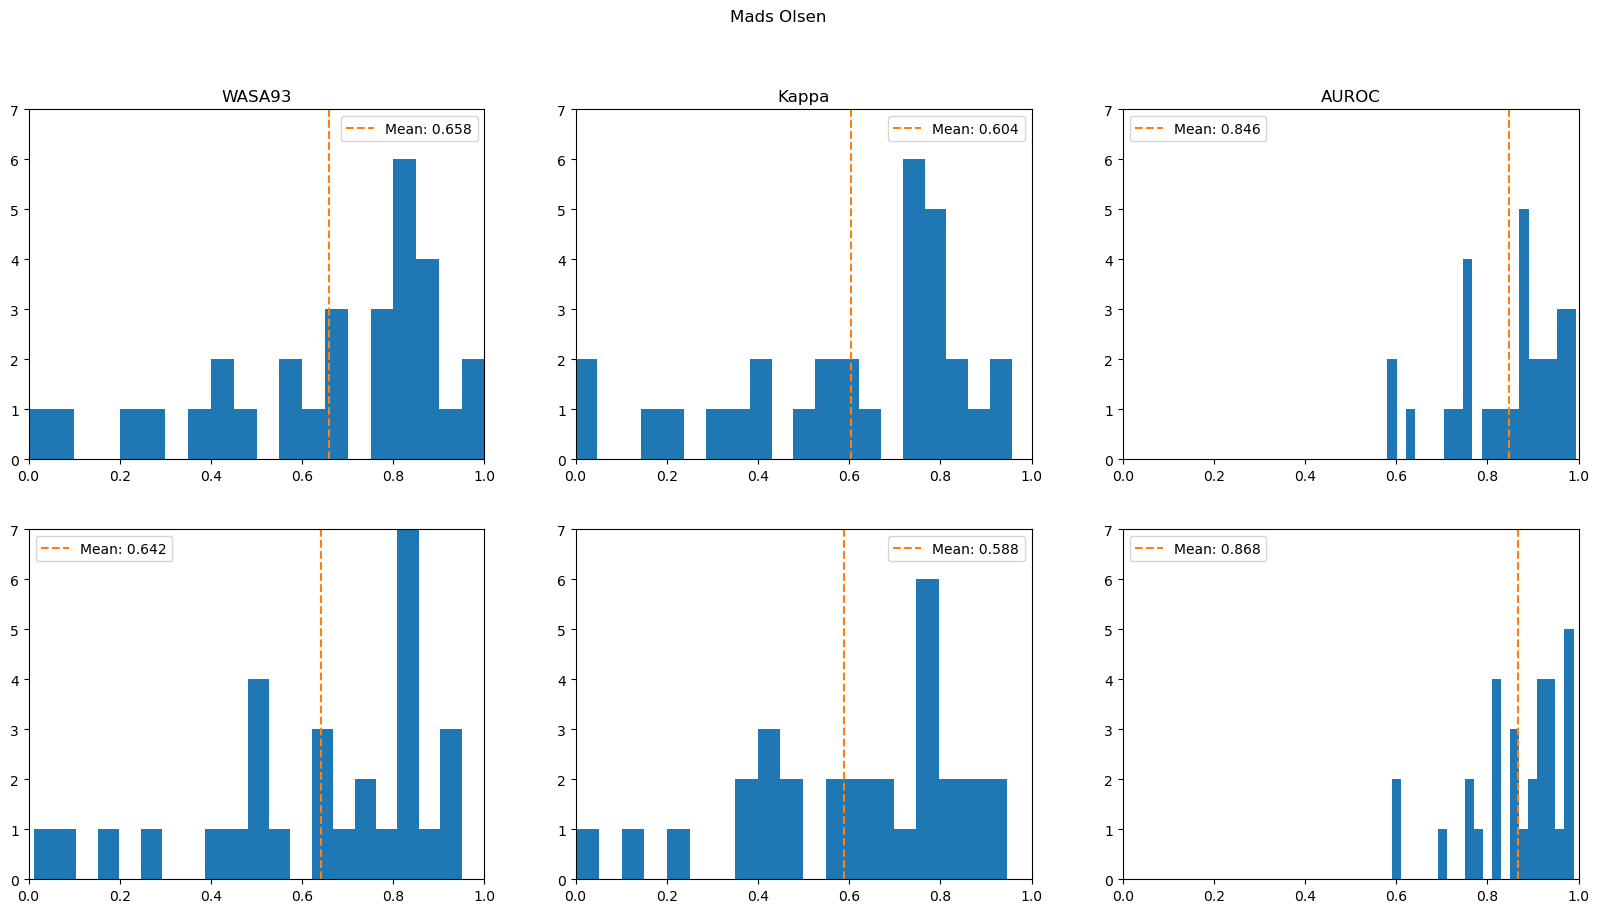

In [25]:
log_reg_wasa_93_hybrid = [e[f"wasa93"] for e in log_reg_evaluations_hybrid]
mo_wasa_93_hybrid = [e[f"wasa93"] for e in evaluations_hybrid]
log_reg_kappa_hybrid = [e["kappa"] for e in log_reg_evaluations_hybrid]
mo_kappa_hybrid = [e["kappa"] for e in evaluations_hybrid]


log_reg_wasa_93_walch = [e[f"wasa93"] for e in log_reg_evaluations_walch]
mo_wasa_93_walch = [e[f"wasa93"] for e in evaluations_walch]
log_reg_kappa_walch = [e["kappa"] for e in log_reg_evaluations_walch]
mo_kappa_walch = [e["kappa"] for e in evaluations_walch]

plot_titles = [
    f"WASA{int(WASA_THRESHOLD*100)}",
    "Kappa",
    "AUROC",
]
hybrid_data_to_plot = [
    (log_reg_wasa_93_hybrid, mo_wasa_93_hybrid),
    (log_reg_kappa_hybrid, mo_kappa_hybrid),
    (log_reg_aucs_hybrid, mo_aucs_hybrid),
]

walch_data_to_plot = [
    (log_reg_wasa_93_walch, mo_wasa_93_walch),
    (log_reg_kappa_walch, mo_kappa_walch),
    (log_reg_aucs_walch, mo_aucs_walch),
]

ncol = 3
fig_lr, ax_lr = plt.subplots(nrows=2, ncols=ncol, figsize=(20, 10))
fig_mo, ax_mo = plt.subplots(nrows=2, ncols=ncol, figsize=(20, 10))

fig_lr.suptitle("Logistic Regression")
fig_mo.suptitle("Mads Olsen")


for i, pair in enumerate(walch_data_to_plot):
    lr, mo = pair
    plot_scores_PDF(lr, ax=ax_lr[0, i])
    plot_scores_PDF(mo, ax=ax_mo[0, i])

    ax_lr[0, i].set_title(plot_titles[i])
    ax_mo[0, i].set_title(plot_titles[i])
    ax_lr[0, i].legend()
    ax_mo[0, i].legend()

for i, pair in enumerate(hybrid_data_to_plot):
    lr, mo = pair
    plot_scores_PDF(lr, ax=ax_lr[1, i])
    plot_scores_PDF(mo, ax=ax_mo[1, i])

    ax_lr[1, i].legend()
    ax_mo[1, i].legend()

for ax_set in [ax_lr, ax_mo]:
    for i in range(ncol):
        for j in range(2):
            ax_set[j, i].set_ylim(0, 7)
